In [1]:
import os
import shutil
import numpy as np
import pickle
import optuna
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import random_split

from Arwin.dataset.synthetic_dataset import SyntheticDataset
from Arwin.model.trainer import Trainer
from Arwin.model.deeponet import *
from Arwin.src.utils import collate_fn_fixed

from torch.utils.tensorboard import SummaryWriter

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 256
data_path = 'Arwin/dataset/synthetic_dataset.pkl'

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
synthetic_dataset = SyntheticDataset(100000, 128, padding=False, verbose=True)

with open(data_path, 'wb') as f:
    pickle.dump(synthetic_dataset, f)

Sampling Functions from Beta Distribution 1/3 with a=2, b=5: 100%|██████████| 33333/33333 [02:05<00:00, 266.47it/s]
Sampling Functions from Beta Distribution 2/3 with a=3, b=3:  33%|███▎      | 10882/33333 [00:37<01:07, 333.66it/s]

In [2]:
synthetic_dataset = pickle.load(open(data_path, 'rb'))

[-2.15035028 -2.04386119 -1.93700225 -1.82989286 -1.72265612 -1.61541823
 -1.50830777 -1.40145618 -1.29499655 -1.18906442 -1.08379413 -0.97932509
 -0.87579237 -0.77333377 -0.67208549 -0.57218301 -0.47376033 -0.37694924
 -0.28187997 -0.18867889 -0.09747018 -0.00837415  0.07849316  0.16302006
  0.24509921  0.32462853  0.40151085  0.47565566  0.54697717  0.61539695
  0.68084235  0.74324762  0.80255344  0.85870765  0.91166504  0.96138793
  1.00784566  1.05101505  1.09087915  1.12742903  1.16066362  1.19058792
  1.21721382  1.24056071  1.26065404  1.27752686  1.29121747  1.30177001
  1.30923548  1.31366998  1.3151347   1.31369519  1.30942302  1.30239302
  1.29268431  1.28037978  1.26556535  1.24832861  1.2287625   1.20695851
  1.18301396  1.15702362  1.12908484  1.09929755  1.06775826  1.03456659
  0.99982014  0.9636163   0.9260515   0.88722098  0.84721737  0.80613331
  0.7640585   0.72107948  0.67728151  0.63274718  0.58755582  0.54178372
  0.49550493  0.4487896   0.40170442  0.35431444  0

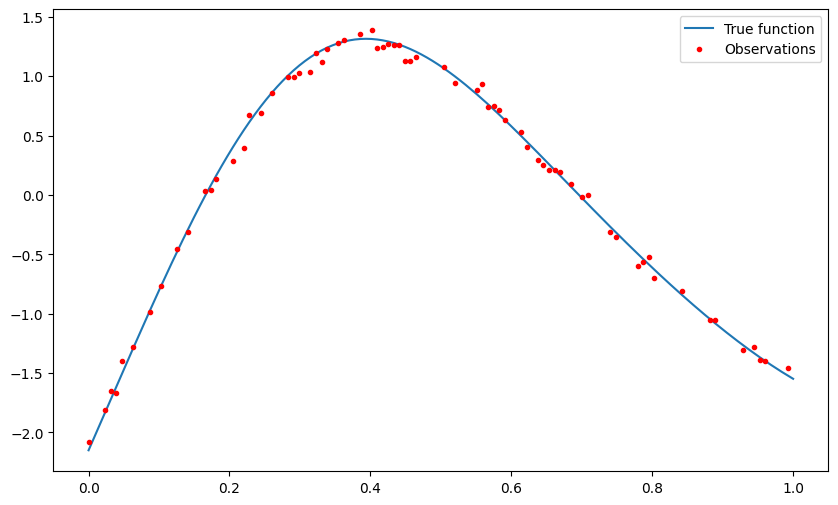

In [ ]:
""" Visualize dataset """

X = np.linspace(0, 1, 128)

for function_values, observations in synthetic_dataset:
    print(function_values)
    observation_values, observation_time_points = observations
    print(observation_time_points)
    print(observation_values)

    plt.figure(figsize=(10,6))
    plt.plot(X, function_values, label='True function')
    plt.plot(observation_time_points, observation_values, marker='.', color='red', linestyle='None', label='Observations')
    plt.legend()
    plt.show()
    break

Only Transformer Encoder, Full Transformer would also require true function values shifted by one which goes against the specifications of the task. Maybe try only Transformer Decoder.

**DeepONet:**

takes two inputs [u(x1), u(x2), . . . , u(xm)] and y in our case u are the random functions and x the signals/observations. y are the points at which the output function is evaluated in our case that should be the points one the fine grid of 128 points. The network wants to learn an operator G in our case that would be the true underlying function.

 <img src="DeepONet.png"  style="width: 50%; height: auto;"/>
 
First there is a “trunk” network, which takes y as the input and outputs $[t_1, t_2, . . . , t_p]^T ∈ R^p$. We note that the trunk network also applies activation functions in the last layer, i.e., $t_k = σ(·)$ for $k = 1, 2, . . . , p$.<br>
A single branch network takes as input $[u(x_1), u(x_2), . . . , u(x_m)]^T$ and outputs a vector $[b_1, b_2, . . . , b_p]^T ∈ R^p$. Both outputs are merged together like:<br>

$G(u)(y) \approx \sum^p_{k=1} = b_k t_k$

Although bias is not necessary in Theorem 1, adding bias to the last layer of the branch network may increase the performance by reducing the generalization error

All versions of DeepONets are implemented in DeepXDE [15], a user-friendly Python library designed for scientific machine learning: https://github.com/lululxvi/deepxde

In [3]:
""" Prepare dataset """

train_ratio = 0.8
validation_ratio = 0.2
dataset_size = len(synthetic_dataset)
train_size = int(train_ratio * dataset_size)
validation_size = dataset_size - train_size
train_dataset, validation_dataset = random_split(synthetic_dataset, [train_size, validation_size])

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn_fixed)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn_fixed)

## Optuna

In [ ]:
def define_model(trial):

    heads = trial.suggest_int('heads', 1, 8)
    # endsure that d_model is divisible by heads
    d_model = trial.suggest_int('d_model', 2*heads, 64*heads, step=heads)
    p = trial.suggest_int('p', 16, 256)

    # d_model = 128
    # heads = 2
    # p = 128
    indicator_dim = 128

    deeponet = DeepONetJan(indicator_dim=indicator_dim, d_model=d_model, heads=heads, p=p).to(device)

    return deeponet

def objective(trial):
    
    model = define_model(trial)
    criterion = nn.MSELoss()

    # trial.suggest_float('lr', 1e-5, 1e-1, log=True)
    # trial.suggest_categorical("optimizer", ["Adam", "AdamW"])
    # trial.suggest_categorical("scheduler", ["CombinedScheduler", "InverseSquareRootLR"])

    # if trial.params["scheduler"] == "InverseSquareRootLR":
    #     trial.suggest_float("min_lr", 1e-9, trial.params["lr"], log=True)

    # trainer = Trainer(model, criterion, train_loader, validation_loader, modelname="Optuna", epochs=2, optuna_trial=trial, verbose=False)
    trainer = Trainer(model, criterion, train_loader, validation_loader, modelname="Optuna", epochs=2, optuna_trial=trial, optuna_model=True, verbose=False)
    loss = trainer.fit()
    
    return loss

In [ ]:
study = optuna.create_study(
    direction="minimize",
    study_name="model_params_study",
    storage="sqlite:///Arwin/src/model_params_study.db", # Save study results in a database
    load_if_exists=True
)
study.optimize(objective, n_trials=50)

pruned_trials = study.get_trials(deepcopy=False, states=[optuna.trial.TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[optuna.trial.TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

  0%|          | 0/313 [00:02<?, ?it/s]
[I 2024-11-16 14:28:36,049] Trial 100 pruned. 
 32%|███▏      | 100/313 [01:23<02:56,  1.20it/s]
[I 2024-11-16 14:29:59,288] Trial 101 pruned. 
 16%|█▌        | 50/313 [00:52<04:34,  1.04s/it]
[I 2024-11-16 14:30:51,681] Trial 102 pruned. 
 16%|█▌        | 50/313 [00:54<04:46,  1.09s/it]
[I 2024-11-16 14:31:46,337] Trial 103 pruned. 
 32%|███▏      | 100/313 [01:28<03:09,  1.12it/s]
[I 2024-11-16 14:33:15,520] Trial 104 pruned. 
 16%|█▌        | 50/313 [00:53<04:40,  1.07s/it]
[I 2024-11-16 14:34:09,085] Trial 105 pruned. 
 16%|█▌        | 50/313 [00:48<04:13,  1.04it/s]
[I 2024-11-16 14:34:57,390] Trial 106 pruned. 
 32%|███▏      | 100/313 [01:32<03:17,  1.08it/s]
[I 2024-11-16 14:36:30,148] Trial 107 pruned. 
  0%|          | 0/313 [00:03<?, ?it/s]
[I 2024-11-16 14:36:33,706] Trial 108 pruned. 
  0%|          | 0/313 [00:02<?, ?it/s]
[I 2024-11-16 14:36:36,587] Trial 109 pruned. 
 32%|███▏      | 100/313 [01:27<03:06,  1.14it/s]
[I 2024-11-16 

 32%|███▏      | 100/313 [01:20<02:51,  1.24it/s]
[I 2024-11-16 15:23:36,565] Trial 143 pruned. 
 16%|█▌        | 50/313 [00:39<03:28,  1.26it/s]
[I 2024-11-16 15:24:16,334] Trial 144 pruned. 
 16%|█▌        | 50/313 [00:40<03:31,  1.24it/s]
[I 2024-11-16 15:24:56,671] Trial 145 pruned. 
  0%|          | 0/313 [00:01<?, ?it/s]
[I 2024-11-16 15:24:58,766] Trial 146 pruned. 
  0%|          | 0/313 [00:03<?, ?it/s]
[I 2024-11-16 15:25:01,958] Trial 147 pruned. 
 32%|███▏      | 100/313 [01:37<03:27,  1.02it/s]
[I 2024-11-16 15:26:39,754] Trial 148 pruned. 
  0%|          | 0/313 [00:02<?, ?it/s]
[I 2024-11-16 15:26:42,527] Trial 149 pruned. 


Study statistics: 
  Number of finished trials:  150
  Number of pruned trials:  138
  Number of complete trials:  12
Best trial:
  Value:  0.04303868209906653
  Params: 
    heads: 3
    d_model: 120
    p: 135


## Results of Optuna Study for number of heads, d_model and p

Best trial:
  Value:  0.04303868209906653
  Params: 
    heads: 3
    d_model: 120
    p: 135


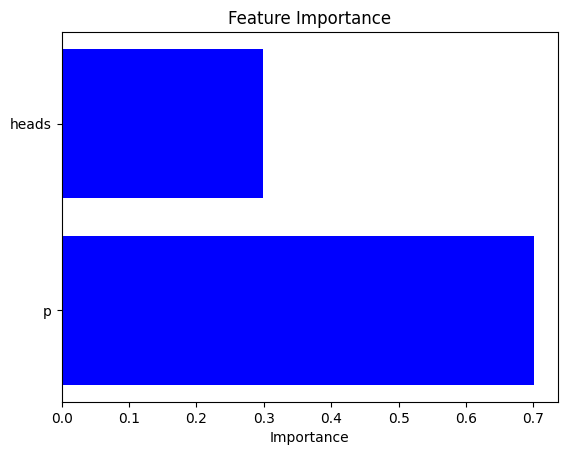

/tmp/ipykernel_545/3767353661.py:18: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_contour(study, params=['heads', 'd_model'])
[W 2024-11-16 15:44:50,627] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.
/tmp/ipykernel_545/3767353661.py:19: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_contour(study, params=['heads', 'p'])
[W 2024-11-16 15:44:50,706] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.
/tmp/ipykernel_545/3767353661.py:20: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_contour(study, params=['d_mod

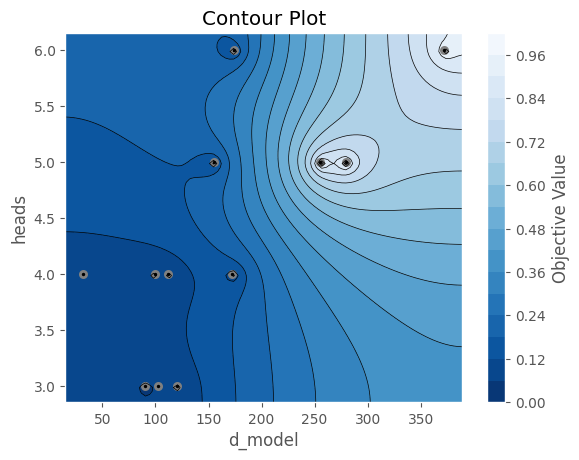

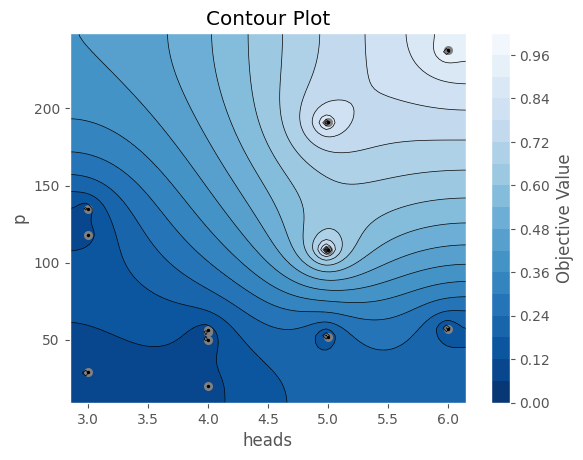

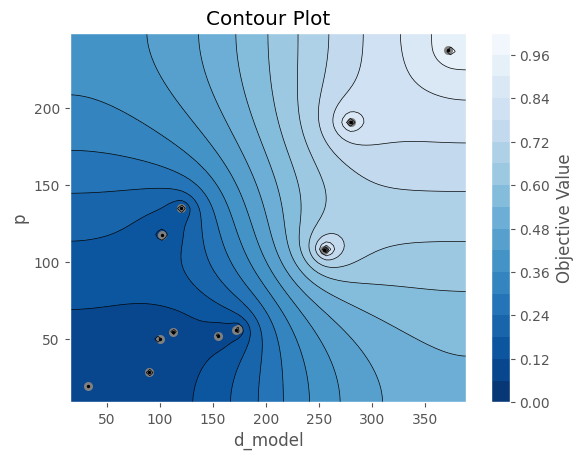

In [5]:
study = optuna.load_study(study_name="model_params_study", storage="sqlite:///Arwin/src/model_params_study.db")

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

optuna_dict = optuna.importance.get_param_importances(study)
plt.barh(list(optuna_dict.keys()), list(optuna_dict.values()), color='blue')
plt.xlabel("Importance")
plt.title("Feature Importance")
plt.show()

optuna.visualization.matplotlib.plot_contour(study, params=['heads', 'd_model'])
optuna.visualization.matplotlib.plot_contour(study, params=['heads', 'p'])
optuna.visualization.matplotlib.plot_contour(study, params=['d_model', 'p'])
plt.show()

## Results of Optuna Study for LR, Optimizer and Scheduler

Best trial:
  Value:  0.04102091352437057
  Params: 
    lr: 0.0004698495364117979
    optimizer: AdamW
    scheduler: InverseSquareRootLR
    min_lr: 1.9166903037985866e-05


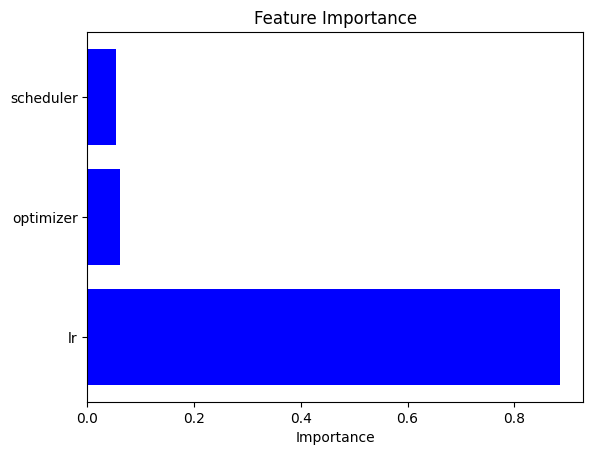

/tmp/ipykernel_1165/1922880279.py:16: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_contour(study, params=['lr', 'scheduler'])
[W 2024-11-15 16:51:49,965] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.
/tmp/ipykernel_1165/1922880279.py:17: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_contour(study, params=['lr', 'optimizer'])
[W 2024-11-15 16:51:50,041] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.
/tmp/ipykernel_1165/1922880279.py:18: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_contour(study, params=

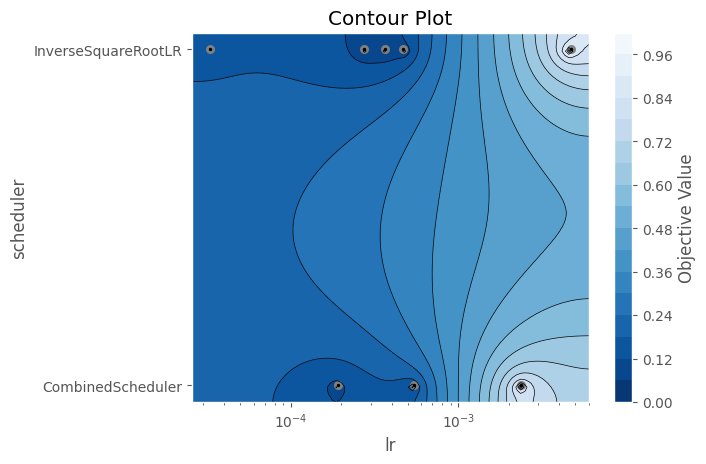

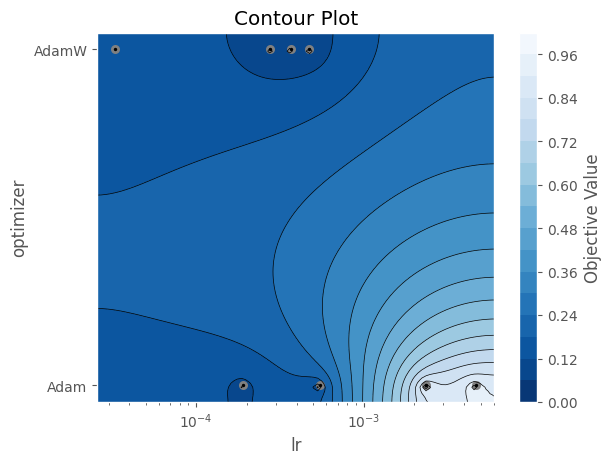

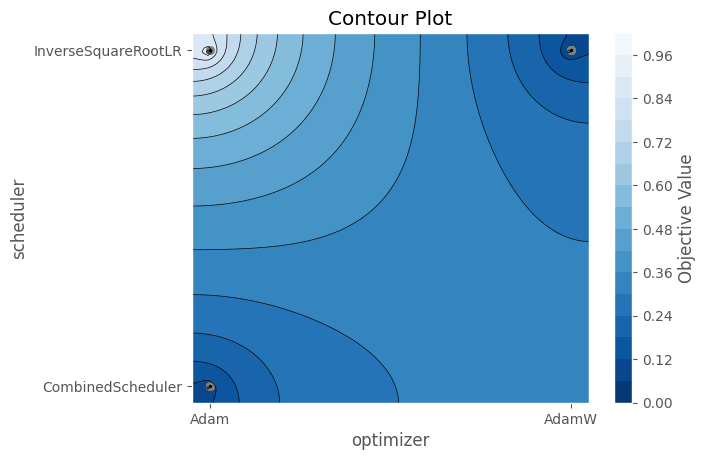

In [6]:
print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

optuna_dict = optuna.importance.get_param_importances(study)
plt.barh(list(optuna_dict.keys()), list(optuna_dict.values()), color='blue')
plt.xlabel("Importance")
plt.title("Feature Importance")
plt.show()

optuna.visualization.matplotlib.plot_contour(study, params=['lr', 'scheduler'])
optuna.visualization.matplotlib.plot_contour(study, params=['lr', 'optimizer'])
optuna.visualization.matplotlib.plot_contour(study, params=['optimizer', 'scheduler'])
plt.show()

In [4]:
TBOARD_LOGS = os.path.join("./Arwin", "tboard_logs", "model_final")
if not os.path.exists(TBOARD_LOGS):
    os.makedirs(TBOARD_LOGS)
shutil.rmtree(TBOARD_LOGS) 
writer = SummaryWriter(TBOARD_LOGS)

indicator_dim = 128

deeponet = DeepONetJan(indicator_dim=indicator_dim, d_model=128, heads=2, p=128).to(device)
criterion = nn.MSELoss()
trainer = Trainer(model=deeponet, criterion=criterion, train_loader=train_loader, valid_loader=validation_loader, modelname="model_final", epochs=20, writer=writer)

In [ ]:
trainer.fit()

Ep 0 Iter 1: Loss=8.23831:   0%|          | 0/313 [00:01<?, ?it/s]

Valid loss @ iteration 0: Loss=1.8294808934716618


Ep 0 Iter 51: Loss=0.48336:  16%|█▌        | 50/313 [00:52<04:23,  1.00s/it]

Valid loss @ iteration 50: Loss=0.5060665700949875


Ep 0 Iter 101: Loss=0.24127:  32%|███▏      | 100/313 [01:45<03:30,  1.01it/s]

Valid loss @ iteration 100: Loss=0.2446500466150396


Ep 0 Iter 151: Loss=0.17117:  48%|████▊     | 150/313 [02:37<02:43,  1.00s/it]

Valid loss @ iteration 150: Loss=0.16968069532338312


Ep 0 Iter 201: Loss=0.21741:  64%|██████▍   | 200/313 [03:29<01:54,  1.01s/it]

Valid loss @ iteration 200: Loss=0.25570660332838696


Ep 0 Iter 251: Loss=0.08078:  80%|███████▉  | 250/313 [04:21<01:01,  1.03it/s]

Valid loss @ iteration 250: Loss=0.09137315200824364


Ep 0 Iter 301: Loss=0.08868:  96%|█████████▌| 300/313 [05:14<00:12,  1.01it/s]

Valid loss @ iteration 300: Loss=0.07761660532331933


Ep 1 Iter 38: Loss=0.0854:  12%|█▏        | 37/313 [00:40<04:27,  1.03it/s] 

Valid loss @ iteration 350: Loss=0.07947807306168127


Ep 1 Iter 88: Loss=0.10117:  28%|██▊       | 87/313 [01:32<03:45,  1.00it/s]

Valid loss @ iteration 400: Loss=0.06827360954062611


Ep 1 Iter 138: Loss=0.06928:  44%|████▍     | 137/313 [02:24<02:53,  1.01it/s]

Valid loss @ iteration 450: Loss=0.06472698825539328


Ep 1 Iter 188: Loss=0.06562:  60%|█████▉    | 187/313 [03:15<02:04,  1.01it/s]

Valid loss @ iteration 500: Loss=0.05824297104103893


Ep 1 Iter 238: Loss=0.0618:  76%|███████▌  | 237/313 [04:07<01:14,  1.03it/s] 

Valid loss @ iteration 550: Loss=0.054367241248780604


Ep 1 Iter 288: Loss=0.0624:  92%|█████████▏| 287/313 [04:59<00:25,  1.01it/s] 

Valid loss @ iteration 600: Loss=0.04844372252038881


Ep 2 Iter 25: Loss=0.04961:   8%|▊         | 24/313 [00:26<05:03,  1.05s/it]

Valid loss @ iteration 650: Loss=0.04873942430405056


Ep 2 Iter 75: Loss=0.03789:  24%|██▎       | 74/313 [01:21<04:11,  1.05s/it]

Valid loss @ iteration 700: Loss=0.04787388984479156


Ep 2 Iter 125: Loss=0.03934:  40%|███▉      | 124/313 [02:14<03:08,  1.00it/s]

Valid loss @ iteration 750: Loss=0.04290879663883471


Ep 2 Iter 175: Loss=0.0423:  56%|█████▌    | 174/313 [03:07<02:20,  1.01s/it] 

Valid loss @ iteration 800: Loss=0.04324999338417661


Ep 2 Iter 225: Loss=0.03103:  72%|███████▏  | 224/313 [03:59<01:26,  1.03it/s]

Valid loss @ iteration 850: Loss=0.04143982384280831


Ep 2 Iter 275: Loss=0.03904:  88%|████████▊ | 274/313 [04:51<00:38,  1.00it/s]

Valid loss @ iteration 900: Loss=0.04427338179712202


Ep 3 Iter 12: Loss=0.04465:   4%|▎         | 11/313 [00:12<05:00,  1.01it/s]

Valid loss @ iteration 950: Loss=0.03805469060499294


Ep 3 Iter 62: Loss=0.0457:  19%|█▉        | 61/313 [01:04<04:09,  1.01it/s] 

Valid loss @ iteration 1000: Loss=0.04127307557592205


Ep 3 Iter 112: Loss=0.03269:  35%|███▌      | 111/313 [01:57<03:24,  1.01s/it]

Valid loss @ iteration 1050: Loss=0.041067318954304155


Ep 3 Iter 162: Loss=0.04119:  51%|█████▏    | 161/313 [02:49<02:32,  1.00s/it]

Valid loss @ iteration 1100: Loss=0.03785964766261624


Ep 3 Iter 212: Loss=0.04922:  67%|██████▋   | 211/313 [03:41<01:42,  1.01s/it]

Valid loss @ iteration 1150: Loss=0.039542005123460996


Ep 3 Iter 262: Loss=0.03443:  83%|████████▎ | 261/313 [04:34<00:51,  1.01it/s]

Valid loss @ iteration 1200: Loss=0.037287473021184694


Ep 3 Iter 312: Loss=0.03344:  99%|█████████▉| 311/313 [05:26<00:01,  1.01it/s]

Valid loss @ iteration 1250: Loss=0.034908089531110784


Ep 4 Iter 49: Loss=0.04781:  15%|█▌        | 48/313 [00:49<04:26,  1.00s/it]

Valid loss @ iteration 1300: Loss=0.03648272675334239


Ep 4 Iter 99: Loss=0.03454:  31%|███▏      | 98/313 [01:41<03:37,  1.01s/it]

Valid loss @ iteration 1350: Loss=0.03452127288077392


Ep 4 Iter 149: Loss=0.04133:  47%|████▋     | 148/313 [02:34<02:43,  1.01it/s]

Valid loss @ iteration 1400: Loss=0.034570762485850094


Ep 4 Iter 199: Loss=0.02376:  63%|██████▎   | 198/313 [03:26<01:54,  1.01it/s]

Valid loss @ iteration 1450: Loss=0.033955090368787445


Ep 4 Iter 249: Loss=0.03106:  79%|███████▉  | 248/313 [04:18<01:04,  1.01it/s]

Valid loss @ iteration 1500: Loss=0.03347318188524714


Ep 4 Iter 299: Loss=0.0256:  95%|█████████▌| 298/313 [05:10<00:15,  1.01s/it] 

Valid loss @ iteration 1550: Loss=0.034705404776568506


Ep 5 Iter 36: Loss=0.03995:  11%|█         | 35/313 [00:35<04:41,  1.01s/it]

Valid loss @ iteration 1600: Loss=0.032616020855950376


Ep 5 Iter 86: Loss=0.03795:  27%|██▋       | 85/313 [01:28<03:51,  1.01s/it]

Valid loss @ iteration 1650: Loss=0.03254253322295114


Ep 5 Iter 136: Loss=0.02619:  43%|████▎     | 135/313 [02:20<02:55,  1.01it/s]

Valid loss @ iteration 1700: Loss=0.03244080617293423


Ep 5 Iter 186: Loss=0.0385:  59%|█████▉    | 185/313 [03:12<02:06,  1.01it/s] 

Valid loss @ iteration 1750: Loss=0.032905420251921114


Ep 5 Iter 236: Loss=0.01761:  75%|███████▌  | 235/313 [04:04<01:15,  1.03it/s]

Valid loss @ iteration 1800: Loss=0.03199777050929911


Ep 5 Iter 286: Loss=0.0422:  91%|█████████ | 285/313 [04:55<00:26,  1.04it/s] 

Valid loss @ iteration 1850: Loss=0.030389622072963154


Ep 6 Iter 23: Loss=0.03442:   7%|▋         | 22/313 [00:22<04:44,  1.02it/s]

Valid loss @ iteration 1900: Loss=0.030781064876446537


Ep 6 Iter 73: Loss=0.04526:  23%|██▎       | 72/313 [01:13<03:58,  1.01it/s]

Valid loss @ iteration 1950: Loss=0.03503496156019323


Ep 6 Iter 123: Loss=0.02173:  39%|███▉      | 122/313 [02:05<03:08,  1.01it/s]

Valid loss @ iteration 2000: Loss=0.029424705378272954


Ep 6 Iter 173: Loss=0.03272:  55%|█████▍    | 172/313 [02:57<02:23,  1.01s/it]

Valid loss @ iteration 2050: Loss=0.030564351372566877


Ep 6 Iter 223: Loss=0.02519:  71%|███████   | 222/313 [03:49<01:30,  1.01it/s]

Valid loss @ iteration 2100: Loss=0.029625479570206475


Ep 6 Iter 273: Loss=0.02867:  87%|████████▋ | 272/313 [04:41<00:41,  1.00s/it]

Valid loss @ iteration 2150: Loss=0.03110970965787476


Ep 7 Iter 10: Loss=0.02427:   3%|▎         | 9/313 [00:09<05:02,  1.00it/s]

Valid loss @ iteration 2200: Loss=0.028225555358564153


Ep 7 Iter 60: Loss=0.03209:  19%|█▉        | 59/313 [01:01<04:09,  1.02it/s]

Valid loss @ iteration 2250: Loss=0.02954907404879729


Ep 7 Iter 110: Loss=0.03535:  35%|███▍      | 109/313 [01:53<03:22,  1.01it/s]

Valid loss @ iteration 2300: Loss=0.029300430095663257


Ep 7 Iter 160: Loss=0.01666:  51%|█████     | 159/313 [02:44<02:31,  1.02it/s]

Valid loss @ iteration 2350: Loss=0.027328126698586287


Ep 7 Iter 210: Loss=0.03065:  67%|██████▋   | 209/313 [03:36<01:41,  1.03it/s]

Valid loss @ iteration 2400: Loss=0.027494723945125647


Ep 7 Iter 260: Loss=0.0371:  83%|████████▎ | 259/313 [04:28<00:52,  1.02it/s] 

Valid loss @ iteration 2450: Loss=0.0273139770781877


Ep 7 Iter 310: Loss=0.02827:  99%|█████████▊| 309/313 [05:20<00:04,  1.01s/it]

Valid loss @ iteration 2500: Loss=0.027424263530502133


Ep 8 Iter 47: Loss=0.03102:  15%|█▍        | 46/313 [00:46<04:25,  1.01it/s]

Valid loss @ iteration 2550: Loss=0.026767311873389224


Ep 8 Iter 97: Loss=0.02268:  31%|███       | 96/313 [01:39<03:28,  1.04it/s]

Valid loss @ iteration 2600: Loss=0.027359855890858407


Ep 8 Iter 147: Loss=0.02462:  47%|████▋     | 146/313 [02:31<02:47,  1.00s/it]

Valid loss @ iteration 2650: Loss=0.02578231201087143


Ep 8 Iter 197: Loss=0.02894:  63%|██████▎   | 196/313 [03:22<01:53,  1.03it/s]

Valid loss @ iteration 2700: Loss=0.025731449051961012


Ep 8 Iter 247: Loss=0.02509:  79%|███████▊  | 246/313 [04:14<01:06,  1.01it/s]

Valid loss @ iteration 2750: Loss=0.025923396990287537


Ep 8 Iter 297: Loss=0.03172:  95%|█████████▍| 296/313 [05:05<00:16,  1.01it/s]

Valid loss @ iteration 2800: Loss=0.026693322129693685


Ep 9 Iter 34: Loss=0.03071:  11%|█         | 33/313 [00:33<04:42,  1.01s/it]

Valid loss @ iteration 2850: Loss=0.02549169435366696


Ep 9 Iter 84: Loss=0.01722:  27%|██▋       | 83/313 [01:25<03:52,  1.01s/it]

Valid loss @ iteration 2900: Loss=0.027194540472883805


Ep 9 Iter 134: Loss=0.01461:  42%|████▏     | 133/313 [02:16<02:53,  1.04it/s]

Valid loss @ iteration 2950: Loss=0.02472915233788537


Ep 9 Iter 184: Loss=0.02635:  58%|█████▊    | 183/313 [03:08<02:10,  1.00s/it]

Valid loss @ iteration 3000: Loss=0.026167252995804243


Ep 9 Iter 234: Loss=0.02313:  74%|███████▍  | 233/313 [03:59<01:16,  1.04it/s]

Valid loss @ iteration 3050: Loss=0.025225126604531325


Ep 9 Iter 284: Loss=0.02128:  90%|█████████ | 283/313 [04:51<00:29,  1.02it/s]

Valid loss @ iteration 3100: Loss=0.025042139870278975


Ep 10 Iter 21: Loss=0.02456:   6%|▋         | 20/313 [00:20<04:52,  1.00it/s]

Valid loss @ iteration 3150: Loss=0.025188755390106465


Ep 10 Iter 71: Loss=0.02732:  22%|██▏       | 70/313 [01:12<03:57,  1.02it/s]

Valid loss @ iteration 3200: Loss=0.02456916941731584


Ep 10 Iter 121: Loss=0.0312:  38%|███▊      | 120/313 [02:03<03:12,  1.00it/s] 

Valid loss @ iteration 3250: Loss=0.030240193776348057


Ep 10 Iter 171: Loss=0.02765:  54%|█████▍    | 170/313 [02:55<02:17,  1.04it/s]

Valid loss @ iteration 3300: Loss=0.02451778477167382


Ep 10 Iter 221: Loss=0.0261:  70%|███████   | 220/313 [03:46<01:29,  1.04it/s] 

Valid loss @ iteration 3350: Loss=0.024757798359382386


Ep 10 Iter 271: Loss=0.03117:  86%|████████▋ | 270/313 [04:37<00:41,  1.03it/s]

Valid loss @ iteration 3400: Loss=0.02350241630612051


Ep 11 Iter 8: Loss=0.03131:   2%|▏         | 7/313 [00:07<05:03,  1.01it/s]

Valid loss @ iteration 3450: Loss=0.02505073824203482


Ep 11 Iter 58: Loss=0.01812:  18%|█▊        | 57/313 [00:59<04:11,  1.02it/s]

Valid loss @ iteration 3500: Loss=0.02330470342627343


Ep 11 Iter 108: Loss=0.01737:  34%|███▍      | 107/313 [01:49<03:19,  1.03it/s]

Valid loss @ iteration 3550: Loss=0.02440581474380166


Ep 11 Iter 158: Loss=0.03076:  50%|█████     | 157/313 [02:41<02:33,  1.01it/s]

Valid loss @ iteration 3600: Loss=0.024175056840713118


Ep 11 Iter 208: Loss=0.01604:  66%|██████▌   | 207/313 [03:33<01:43,  1.02it/s]

Valid loss @ iteration 3650: Loss=0.023651694148486734


Ep 11 Iter 258: Loss=0.03251:  82%|████████▏ | 257/313 [04:23<00:53,  1.05it/s]

Valid loss @ iteration 3700: Loss=0.023356036082202315


Ep 11 Iter 308: Loss=0.02841:  98%|█████████▊| 307/313 [05:14<00:05,  1.00it/s]

Valid loss @ iteration 3750: Loss=0.023754052562164327


Ep 12 Iter 45: Loss=0.01676:  14%|█▍        | 44/313 [00:44<04:28,  1.00it/s]

Valid loss @ iteration 3800: Loss=0.022748324654850306


Ep 12 Iter 95: Loss=0.01684:  30%|███       | 94/313 [01:36<03:29,  1.04it/s]

Valid loss @ iteration 3850: Loss=0.022214335480741428


Ep 12 Iter 145: Loss=0.02739:  46%|████▌     | 144/313 [02:27<02:43,  1.03it/s]

Valid loss @ iteration 3900: Loss=0.022193660046540054


Ep 12 Iter 195: Loss=0.01918:  62%|██████▏   | 194/313 [03:18<01:54,  1.04it/s]

Valid loss @ iteration 3950: Loss=0.02322012671799052


Ep 12 Iter 245: Loss=0.02634:  78%|███████▊  | 244/313 [04:10<01:06,  1.03it/s]

Valid loss @ iteration 4000: Loss=0.02264865370942097


Ep 12 Iter 295: Loss=0.02529:  94%|█████████▍| 294/313 [05:01<00:18,  1.02it/s]

Valid loss @ iteration 4050: Loss=0.026300486012854996


Ep 13 Iter 32: Loss=0.02215:  10%|▉         | 31/313 [00:31<04:41,  1.00it/s]

Valid loss @ iteration 4100: Loss=0.021985624222924896


Ep 13 Iter 82: Loss=0.02208:  26%|██▌       | 81/313 [01:23<03:53,  1.01s/it]

Valid loss @ iteration 4150: Loss=0.02204759778710557


Ep 13 Iter 132: Loss=0.02027:  42%|████▏     | 131/313 [02:15<03:00,  1.01it/s]

Valid loss @ iteration 4200: Loss=0.02385505345449144


Ep 13 Iter 182: Loss=0.01941:  58%|█████▊    | 181/313 [03:06<02:12,  1.00s/it]

Valid loss @ iteration 4250: Loss=0.022373349314519002


Ep 13 Iter 232: Loss=0.02283:  74%|███████▍  | 231/313 [03:58<01:21,  1.00it/s]

Valid loss @ iteration 4300: Loss=0.0228617668115333


Ep 13 Iter 282: Loss=0.01793:  90%|████████▉ | 281/313 [04:51<00:32,  1.02s/it]

Valid loss @ iteration 4350: Loss=0.021863007004938873


Ep 14 Iter 19: Loss=0.01453:   6%|▌         | 18/313 [00:18<04:52,  1.01it/s]

Valid loss @ iteration 4400: Loss=0.022019266936124538


Ep 14 Iter 69: Loss=0.0157:  22%|██▏       | 68/313 [01:10<04:05,  1.00s/it] 

Valid loss @ iteration 4450: Loss=0.022307504224134425


Ep 14 Iter 119: Loss=0.02321:  38%|███▊      | 118/313 [02:02<03:14,  1.00it/s]

Valid loss @ iteration 4500: Loss=0.022111089279254276


Ep 14 Iter 169: Loss=0.01468:  54%|█████▎    | 168/313 [02:54<02:22,  1.02it/s]

Valid loss @ iteration 4550: Loss=0.02118755811277558


Ep 14 Iter 219: Loss=0.01948:  70%|██████▉   | 218/313 [03:46<01:35,  1.01s/it]

Valid loss @ iteration 4600: Loss=0.023203985875143725


Ep 14 Iter 269: Loss=0.02405:  86%|████████▌ | 268/313 [04:38<00:44,  1.01it/s]

Valid loss @ iteration 4650: Loss=0.022070693746939592


Ep 15 Iter 6: Loss=0.02346:   2%|▏         | 5/313 [00:06<05:11,  1.01s/it]

Valid loss @ iteration 4700: Loss=0.02157116277764241


Ep 15 Iter 56: Loss=0.01507:  18%|█▊        | 55/313 [00:57<04:15,  1.01it/s]

Valid loss @ iteration 4750: Loss=0.020805154123580923


Ep 15 Iter 106: Loss=0.01858:  34%|███▎      | 105/313 [01:50<03:28,  1.00s/it]

Valid loss @ iteration 4800: Loss=0.022721543250715032


Ep 15 Iter 156: Loss=0.01744:  50%|████▉     | 155/313 [02:42<02:36,  1.01it/s]

Valid loss @ iteration 4850: Loss=0.02117064441828167


Ep 15 Iter 206: Loss=0.01577:  65%|██████▌   | 205/313 [03:34<01:48,  1.01s/it]

Valid loss @ iteration 4900: Loss=0.02137994864845977


Ep 15 Iter 256: Loss=0.02409:  81%|████████▏ | 255/313 [04:26<00:57,  1.01it/s]

Valid loss @ iteration 4950: Loss=0.02077306819824027


Ep 15 Iter 306: Loss=0.01773:  97%|█████████▋| 305/313 [05:18<00:07,  1.01it/s]

Valid loss @ iteration 5000: Loss=0.020724450438922525


Ep 16 Iter 43: Loss=0.01709:  13%|█▎        | 42/313 [00:43<04:35,  1.02s/it]

Valid loss @ iteration 5050: Loss=0.020640220730474182


Ep 16 Iter 93: Loss=0.01918:  29%|██▉       | 92/313 [01:35<03:47,  1.03s/it]

Valid loss @ iteration 5100: Loss=0.02122602555170363


Ep 16 Iter 143: Loss=0.0229:  45%|████▌     | 142/313 [02:27<02:51,  1.00s/it] 

Valid loss @ iteration 5150: Loss=0.02017637062817812


Ep 16 Iter 193: Loss=0.01983:  61%|██████▏   | 192/313 [03:20<02:02,  1.01s/it]

Valid loss @ iteration 5200: Loss=0.02382480533903136


Ep 16 Iter 243: Loss=0.02265:  77%|███████▋  | 242/313 [04:12<01:11,  1.01s/it]

Valid loss @ iteration 5250: Loss=0.021127957558515025


Ep 16 Iter 293: Loss=0.03487:  93%|█████████▎| 292/313 [05:04<00:21,  1.02s/it]

Valid loss @ iteration 5300: Loss=0.020797462440004535


Ep 17 Iter 30: Loss=0.0138:   9%|▉         | 29/313 [00:30<04:41,  1.01it/s] 

Valid loss @ iteration 5350: Loss=0.020214907313678778


Ep 17 Iter 80: Loss=0.02671:  25%|██▌       | 79/313 [01:22<03:47,  1.03it/s]

Valid loss @ iteration 5400: Loss=0.021852759260903385


Ep 17 Iter 130: Loss=0.02428:  41%|████      | 129/313 [02:13<03:00,  1.02it/s]

Valid loss @ iteration 5450: Loss=0.020605402487311877


Ep 17 Iter 180: Loss=0.0274:  57%|█████▋    | 179/313 [03:06<02:16,  1.02s/it] 

Valid loss @ iteration 5500: Loss=0.020834934331622777


Ep 17 Iter 230: Loss=0.02113:  73%|███████▎  | 229/313 [03:58<01:23,  1.01it/s]

Valid loss @ iteration 5550: Loss=0.021023079223346477


Ep 17 Iter 280: Loss=0.01851:  89%|████████▉ | 279/313 [04:51<00:34,  1.00s/it]

Valid loss @ iteration 5600: Loss=0.02063032561073116


Ep 18 Iter 8: Loss=0.01579:   2%|▏         | 7/313 [00:07<05:04,  1.00it/s]